In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import shapely
import geopandas as gpd

import quickplot as qp

In [2]:
import pysal as ps
ps.version

'1.13.0'

# The modifiable areal unit problem (MAUP) and the electoral college
A classic example of the problems with aggregating data to polygons is provided by electoral geographies. This is particularly dramatized by [*gerrymandering*](http://www.vox.com/cards/gerrymandering-explained/what-is-gerrymandering) when electoral district boundaries are manipulated for the advantage of one side or another.

There are many great online resources on gerrymandering. One I came across recently is this [blog post](http://mike.teczno.com/notes/redistricting.html), which I recommend you read, because it moves beyond a simplistic focus on the *shape* of electoral districts to the much more important aspect of how votes for one or another party are used more or less efficiently to elect representatives as a consequence of manipulation of electoral geography.

## MAUP
The insight (if we can call it that) which underpins gerrymandering, is that the spatial patterns we observe on maps may depend on the set of polygons we use to partition up space and aggregate data.  To see this consider the following example. 

First we make a function that returns a grid of squares as a `GeoDataFrame`.

In [2]:
# Make a 10 x 10 grid of squares
def get_grid(width=10, height=10, noise=0):
    squares = [] 
    row = []
    col = []
    for c in range(width):
        for r in range(height):
            squares.append(shapely.geometry.polygon.Polygon([[c, r], [c, r+1], [c+1, r+1], [c+1, r]]))
            col.append(c)
            row.append(r)
    square_map = gpd.GeoDataFrame(geometry=gpd.GeoSeries(squares))
    square_map.crs = {'init': 'epsg:4326'}
    square_map['column'] = col
    square_map['row'] = row
    square_map['approx_col'] = square_map.column + (noise * np.random.rand(width*height))
    square_map['approx_row'] = square_map.row + (noise * np.random.rand(width*height))
    return square_map

Now use it to make a grid. 

In [3]:
grid = get_grid(width=5, height=5, noise=1)
grid.head()

,geometry,column,row,approx_col,approx_row
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",0,0,0.993878,0.261272
1,"POLYGON ((0 1, 0 2, 1 2, 1 1, 0 1))",0,1,0.353956,1.646021
2,"POLYGON ((0 2, 0 3, 1 3, 1 2, 0 2))",0,2,0.000918,2.010819
3,"POLYGON ((0 3, 0 4, 1 4, 1 3, 0 3))",0,3,0.961932,3.617849
4,"POLYGON ((0 4, 0 5, 1 5, 1 4, 0 4))",0,4,0.589825,4.553806


Now map its **approx_row** and **approx_column** attributes.

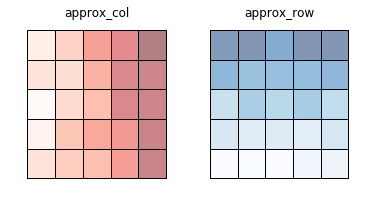

In [4]:
fig = plt.figure(figsize=(6,3))
ax = plt.subplot(121)
ax.set_title('approx_col')
ax.set_axis_off()
grid.plot(ax=ax, column='approx_col', cmap='Reds')
ax = plt.subplot(122)
ax.set_title('approx_row')
ax.set_axis_off()
grid.plot(ax=ax, column='approx_row', cmap='Blues')

Now, use **dissolve** to aggregate the grid into rows or columns, using a sum function to summarize the data in each case.

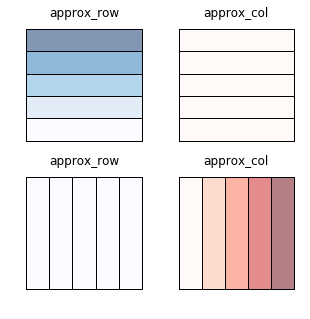

In [5]:
rows = grid.dissolve(by='row', aggfunc='sum', as_index=False)
cols = grid.dissolve(by='column', aggfunc='sum', as_index=False)

## Now map them again
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(221)
ax.set_title('approx_row')
ax.set_axis_off()
rows.plot(ax=ax, column='row', cmap='Blues')
ax = plt.subplot(222)
ax.set_title('approx_col')
ax.set_axis_off()
rows.plot(ax=ax, column='column', cmap='Reds')
ax = plt.subplot(223)
ax.set_title('approx_row')
ax.set_axis_off()
cols.plot(ax=ax, column='row', cmap='Blues')
ax = plt.subplot(224)
ax.set_title('approx_col')
ax.set_axis_off()
cols.plot(ax=ax, column='column', cmap='Reds')


Notice how the two variables are affected differently by each of the aggregation schemes.  Each of them 'survives' one aggregation pattern, but is completely lost by the other.

Clearly, this is a highly artificial case, but the central issue of the **modifiable areal unit problem** is clear: how we aggregate data into polygons affects the patterns we see.  In this case, we have a very clear idea of how the aggregation might be expected to affect the patterns, because we have set the data up to have a very clear spatial structure.  But in general, there is no necessary or obvious prior expectation of the relationship between a set of administrative districts into which we aggregate data (such as zipcode areas, census tracts, police precincts, etc.) and the things we are collating data about (various socio-demographic, cultural or economic characteristics).  

Thus, in an import sense, the boundaries we use may often be effectively *arbitrary* relative to the underlying phenomena and hence *patterns* of interest.

In fact, this example shows how this effect can work both in our favor and against us.  In our favor, because an aggregation scheme can enhance an underlying pattern, or hide it completely.  However, it is generally more likely that MAUP will work against us, obscuring or confusing underlying patterns, rather than revealing or enhancing them.

# The assignment
I am not going to get into here my own view that the real issue with gerrymandering is the non-proportional election system, which can be resolved in many different ways (as it has been in many other countries).

Instead, we are simply going to look at the 2016 Presidential Election, and in particular to consider the ways in which the electoral college interacts with geography. We are going to do this by emulating the concept behind the [Random States of America](http://fakeisthenewreal.org/random-states-of-america/) web page.  (Another nice example with a similar theme is the [Redraw the States](http://kevinhayeswilson.com/redraw/) web page, and the nice examples of work people have done with it that you can find [here](https://medium.com/@khayeswilson/the-best-maps-from-redraw-the-states-538861cc44ed#.dptzw2ci7).)

## Data and a couple of maps
Let's grab the data we'll be working with. I got these from the aforementioned [Redraw the States](http://kevinhayeswilson.com/redraw/) site. The data are not final certified results, but are fine for our purposes here.

Note that any projection information associated with these data are meaningless, as Alaska and Hawaii have been moved, and Alaska rescaled for the map view.

In [11]:
election = gpd.read_file('election.shp')
election.head()

,FID,dem,dempc,geometry,gop,goppc,grn,lib,margin,name,newstate,oth,population,state,una,votes
0,1001,5908,0.239569,"POLYGON ((892112.80012558 1115678.795392964, 8...",18110,0.734358,105,538,0.494789,Autauga,AL,0,54571,AL,0,24661
1,1003,18409,0.195653,"POLYGON ((780232.5698541742 947375.2080644479,...",72780,0.773515,453,2448,0.577862,Baldwin,AL,0,182265,AL,0,94090
2,1005,4848,0.466603,"POLYGON ((1026127.598653847 1057957.143773036,...",5431,0.522714,18,93,0.056112,Barbour,AL,0,27457,AL,0,10390
3,1007,1874,0.214220,"POLYGON ((845034.8675876737 1149437.158844963,...",6733,0.769662,17,124,0.555441,Bibb,AL,0,22915,AL,0,8748
4,1009,2150,0.084699,"POLYGON ((871035.6126721548 1287748.49965, 886...",22808,0.898519,89,337,0.813820,Blount,AL,0,57322,AL,0,25384


The columns here are as follows
* **dem**, **gop**, **grn**, **lib**, **una** and **oth** are the votes cast in each county for the Democratic, Republican, Green, Libertarian, Unaligned (Evan McMullin who ran strongly in Utah), and Other
* **population** is the total population of each county
* **votes** is the total votes cast
* **dempc** and **goppc** are the proportion of total votes cast for the Democratic and Republican preidential candidates
* **margin** is the difference between the proportion of votes cast for the Republican candidate and the Democratic candidate. We could consider changing this to the difference between the winning candidate and all others combined, but this is fine for our present purposes
* **state** is the state to which the county belongs
* **newstate** is a column we will use to assign counties to alternative 'random states'

It's worth mapping these to get a feel for things.

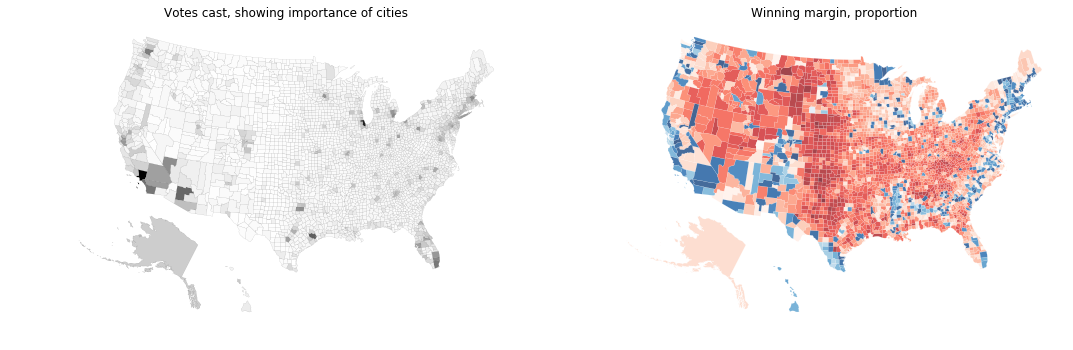

In [12]:
fig = plt.figure(figsize=(18,9))

ax = plt.subplot(121)
ax.set_aspect('equal')
ax.set_axis_off()
ax.set_title('Votes cast, showing importance of cities')

## Note how I take square root to make the colors more useful
## TRY MAPPING votes instead, to see why
election['votes2'] = np.sqrt(election.votes)
qp.quickplot(election, column='votes2', cmap='Greys', alpha=1, edgecolor='k', linewidth=0.05)

ax = plt.subplot(122)
ax.set_aspect('equal')
ax.set_axis_off()
ax.set_title('Winning margin, proportion')

## Note how we draw the D and R wind separately to ensure that 'white' is the low margin cases
qp.quickplot(election[election.margin>0], column='margin', cmap='Reds', edgecolor='w', alpha=0.75, linewidth=0.15)
qp.quickplot(election[election.margin<=0], column='margin', cmap='Blues', edgecolor='w', alpha=0.75, linewidth=0.15)

## we don't need the votes2 column we added, so drop it
election.drop('votes2', axis=1, inplace=True)

## Making a state election map, using `dissolve`
We see a lot of county maps like the ones above, but it's states that matter for the electoral college, and hence for the outcome. 

In the next cell is a function that will make states from counties, by dissolving them on a specified column in the data. You may need to refer back to the previous session to make complete sense of this.  Note how we have to recalculate the **goppc**, **dempc** and **margin** variables (*WHY?*).  We also add a **win** variable which is helpful later.

In [13]:
# Make states from counties data counties, 
# based on the named state variable provided
# using the dissolve function
def make_states(counties, state='state'):
    states = counties.dissolve(by=state, aggfunc='sum', as_index=False)
    # recalculate the proportion-based variables
    states.dempc = states.dem / states.votes
    states.goppc = states.gop / states.votes
    states.margin = states.goppc - states.dempc
    # add a variable to flag the winner
    # in each state - we'll assume D/R
    states['win'] = 'D'
    states.loc[states.gop > states.dem, 'win'] = 'R'
    return states

Let's see this in action for the actual election result.

In [14]:
states = make_states(election, state='state')
states.head()

,state,geometry,FID,dem,dempc,gop,goppc,grn,lib,margin,oth,population,una,votes,win
0,AK,(POLYGON ((-1882164.772212857 419730.666193547...,2001,93007,0.377176,130415,0.528878,4445,14593,0.151702,4128,710231,0,246588,R
1,AL,"POLYGON ((998843.1210250946 935438.8258693079,...",71489,718084,0.345538,1306925,0.628884,9287,43869,0.283347,0,4779736,0,2078165,R
2,AR,"POLYGON ((439573.2907305224 1177002.465449736,...",380625,378729,0.341624,677904,0.611487,9837,29518,0.269864,12627,2915918,0,1108615,R
3,AZ,POLYGON ((-1365876.729939255 1021579.408853245...,60208,936250,0.453871,1021154,0.495031,25255,80151,0.041159,0,6392017,0,2062810,R
4,CA,(POLYGON ((-2077428.848194205 1354705.72972257...,351364,7230699,0.616243,3841134,0.327364,215694,394239,-0.288879,51757,37253956,0,11733523,D


And now we can make a red state / blue state map

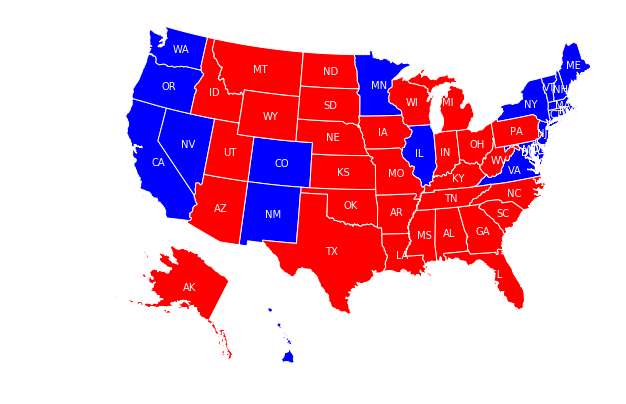

In [15]:
# plot those states
fig, ax = plt.subplots(figsize=(10,7))
ax.set_aspect('equal')
ax.set_axis_off()
for p, t in zip(states.geometry, states.state):
    ax.annotate(xy=(p.centroid.x-60000, p.centroid.y-30000), s=t, color='w')
qp.quickplot(states[states.win=='D'], facecolor='b', alpha=1, edgecolor='w', linewidth=1)
qp.quickplot(states[states.win=='R'], facecolor='r', alpha=1, edgecolor='w', linewidth=1)

## Random states of America
I made a small python module **randomstates** with some functions for making random states. If you are interested in the details take a look inside it from the folder view.

In [21]:
import randomstates as rs
import importlib as imp
rs = imp.reload(rs)

The `random_states()` function in this module does what we need. Before running it, to speed subsequent iterations up, we make a network or *graph* out of the counties data. You will get a warning about disconnected observations&mdash;this relates to Hawaii and Alaska and is not a problem.

In [23]:
G = rs.make_graph(election)

/Users/dosullivan/anaconda/envs/py3/lib/python3.6/site-packages/pysal/weights/weights.py:189: UserWarning: There are 5 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/dosullivan/anaconda/envs/py3/lib/python3.6/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 67, 518, 519, 520, 521
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


You can see what this looks like with the `rs.draw_graph()` function:

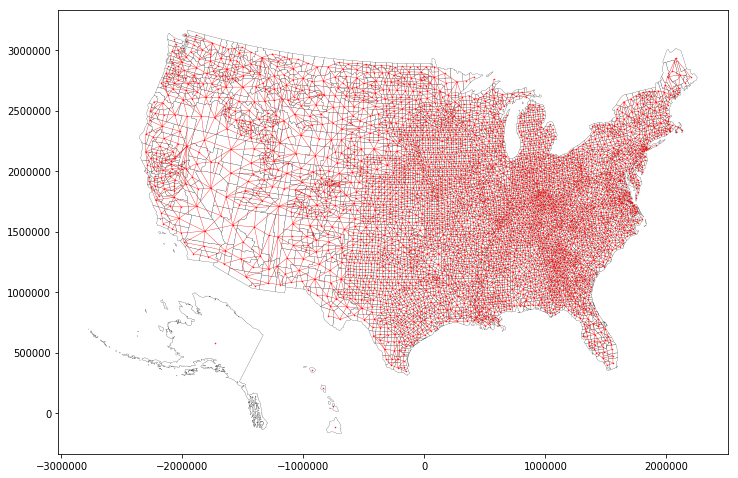

In [24]:
rs.draw_graph(election, G)

My random states code makes use of this network of neighboring counties to partition the counties into different combinations and make 'random states'.  The network structure is needed so I can make sure the resulting states remain connected and don't fall apart.  Again, if you want to know more, ask me about it, or check out the code of the `randomstates` module in the notebook folder.

Now, you simply send the `random_states()` function the `election` GeoDataFrame and associated graph and assign the result to the **newstate** column.  Then you run the `make_states()` function from above, but using the **newstate** variable as the dissolve column.

In [ ]:
election.newstate = rs.random_states(election, GN=G)
states = make_states(election, state='newstate')
states

Note that Alaska (AK) is unchanged (as is Hawaii, HI), but that the populations and total votes and everything else about these 'newstates' have changed.  We can see this in a map.

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)
ax.set_aspect('equal')
ax.set_axis_off()
for p, t in zip(states.geometry, states.newstate):
    ax.annotate(xy=(p.centroid.x-50000, p.centroid.y), s=t, color='k')
qp.quickplot(states, column='population', cmap='OrRd', edgecolor='brown', linewidth=0.2)

Next, we have to *reapportion* the electoral college, based on these new populations, and determine the election results that would follow.  Apportionment is the process of deciding how many electoral college votes each state (and the District of Columbia) gets, and is described in this [wikipedia article](https://en.wikipedia.org/wiki/United_States_congressional_apportionment).

In [ ]:
states['ev'] = rs.apportion(states.population, states.newstate)
states

With that done, we can see how the same county level results, applied to these different states would have led to an overall electoral college outcome.

In [ ]:
gop_ev = sum(states.ev[states.win=='R']) 
dem_ev = sum(states.ev[states.win=='D'])
gop_ev, dem_ev

Finally we can make a map.  This one will show the counties overlaid with the new random states.

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
ax.set_aspect('equal')
for p, t in zip(states.geometry, states.newstate):
    ax.annotate(xy=(p.centroid.x-50000, p.centroid.y-30000), s=t)
qp.quickplot(election, column='goppc', cmap='RdBu_r', linewidth=0.1, edgecolor='w', alpha=0.75)
qp.quickplot(states, column='margin', cmap='RdBu_r', edgecolor='k', linewidth=1, facecolor='w', alpha=0.5)

## All in one go
That's quite a few steps, but in fact the process to make new random states and determine the resulting electoral outcome is pretty simple.

In [ ]:
election.newstate = rs.random_states(election, GN=G)
states = make_states(election, state='newstate')
states['ev'] = rs.apportion(states.population, states.newstate)
gop_ev = sum(states.ev[states.win=='R']) 
dem_ev = sum(states.ev[states.win=='D'])
gop_ev, dem_ev

And a map

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_aspect('equal')
ax.set_axis_off()
for p, t in zip(states.geometry, states.newstate):
    ax.annotate(xy=(p.centroid.x-60000, p.centroid.y-30000), s=t, color='w')
qp.quickplot(states[states.win=='D'], facecolor='b', alpha=1, edgecolor='w', linewidth=1)
qp.quickplot(states[states.win=='R'], facecolor='r', alpha=1, edgecolor='w', linewidth=1)

# What you have to do
So... what's potentially of interest here is to run the election a lot of times (see the examples referenced in the [blog referenced earlier](http://mike.teczno.com/notes/redistricting.html)), with different state boundaries and see how different the election can get.  That's what I'd like you to do.

In the code cell below, write code to run the election with 100 different maps, recording the Republican electoral college vote total each time, and plot a histogram of the results.  

I ***highly recommend*** getting the code running with just one iteration before running it 100 times, which will likely take at least a couple of minutes to complete (that's how long it took running locally on my computer&mdash;it may be a bit slower on datahub).

I've given you a good start on things.

In [ ]:
## make an empty list to record the results
results = []
## you need to run a loop, but to start with
## only iterate once, so you don't have to wait too long!
for i in range(1):
    ## WRITE CODE HERE TO RUN THE ELECTION
    ## WITH A RANDOM SET OF STATES
    ## 
    ## put the result in the list
    results.append(gop_ev) 

## Use the plt.hist() function to show the outcome

## Questions to answer
Double-click in this cell and write your answers to the following questions.  Note that answering these questions might mean going back to the earlier cells that re-run the results to find extreme cases and map them, to get a feel for which kinds of map favor each party the most.

### What were the highest and lowest numbers of electoral college votes obtained by the Republican party in your simulation?

### Roughly what proportion of the random maps did the Republican pary *lose* (the winning line is 269 electoral college votes)?

### Given that the Democratic party had a majority in the popular vote of around 3% what do you make of the electoral college outcomes you have simulated?
